# Bitcoin TimeSeries Predictions

## Synthesis paper "Next-Day Bitcoin Price Forecast" (20 June 2019)

• The price of Bitcoin follows **a boom-bust pattern** due to its speculative nature (Cheah and Fry 2015).<br /> 
• Additionally, Bitcoin investors are **speculative and short term oriented** (Salisu et al. 2019).<br />
• **Bitcoin is an inefficient market**.<br />
• Hybrid-forecasting model to predict Bitcoin price volatility, integrating artificial neural network (ANN), generalised autoregressive conditional heteroscedasticity (GARCH) and principal components analysis (PCA).<br />
• Explanatory variables (i.e., **google trend, trading volume, transaction volume, VIX
index, and unique user addresses**)<br />
• **Testing  autoregressive integrated moving average (ARIMA) and neural network autoregression (NNAR)**.<br />
• Bitcoin as **a speculative investment**. Bitcoin is more volatile and riskier than gold and Euro<br />
• **Stationarity of data is a prerequisite** for predictive modelling, particularly when using
autoregressive time series models such as ARIMA.<br />
• Results of the stationary test of the training-data samples using the Augmented Dicky-Fuller test (ADF) (Dickey and Fuller 1979) and Phillips-Perron test (PP) (Phillips and Perron 1988). Data, both in levels and log-transformed series, are not stationary but **become stationary at first difference log operator**; thus, the ARIMA modelling
approach is feasible. It might be noted that the stationarity of data is not essential for neural network
models (Hyndman and Athanasopoulos 2018).<br />
• Future research on Bitcoin price forecast should consider nested **ARIMA models combining ARCH and
GARCH**.<br />
• **ARIMA forecast results are more accurate** than the NNAR forecasts in the test-sample forecasts<br />
• the NNAR model with re-estimation in each step performs better than without re-estimation.<br /><br />
Source : https://www.mdpi.com/1911-8074/12/2/103/pdf <br />

## Let's first check AR model

In [1]:
# Main librairies
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Web scraping
import requests
from bs4 import BeautifulSoup
from IPython.display import display_html

# Stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# Plus
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_rows', 400)
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Get data from Coin Market Cap
def get_csv_scrap_btc(start_date='20170101',end_date = '20190912'):
    #start_date = '20170101'
    #end_date = '20190912'

    url = f'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={start_date}&end={end_date}'
    r = requests.get(url)
    bitcoin = BeautifulSoup(r.text, 'lxml')

    bitcoin = bitcoin.find_all('table', class_='table')[0]
    html_bitcoin = str(bitcoin)
    bitcoin_stocks = pd.read_html(html_bitcoin)[0]
    
    bitcoin_stocks = pd.DataFrame(bitcoin_stocks)
    bitcoin_stocks['Date'] = pd.to_datetime(bitcoin_stocks['Date'])
    
    return bitcoin_stocks

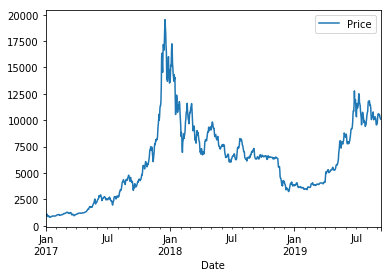

In [3]:
# Prepare the dataframe
df = get_csv_scrap_btc()

df['Price'] = (df['High'] + df['Low']) / 2
df = df[['Date', 'Price']].set_index('Date')

df.plot()

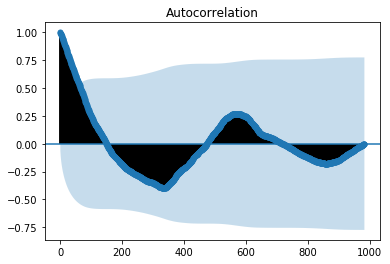

In [4]:
fig = plot_acf(df)

Didn't go in depth, but stationarity is a big thing with time series models.

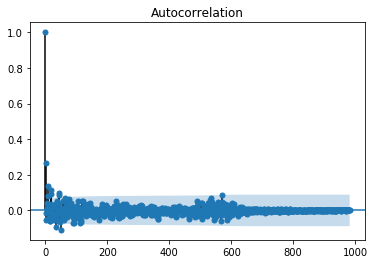

In [5]:
df_diff = df.diff(periods=1)[1:].sort_index()
fig = plot_acf(df_diff)

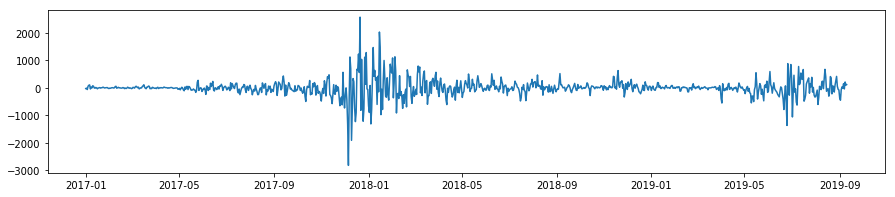

In [6]:
plt.figure(figsize=(15,3))
plt.plot(df_diff)

## Time series can predict BTC price ? (Autoreggresive AR Model)

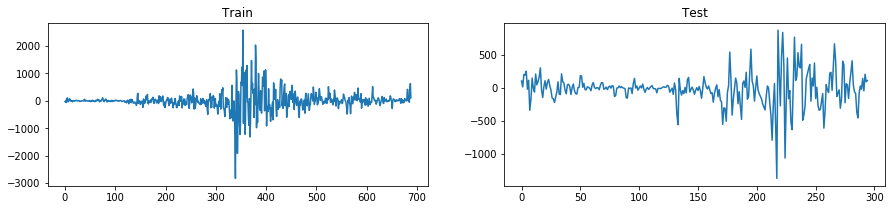

In [7]:
X = df_diff.values
train = X[0:689] # (689, 1)
test = X[688:]  # (295, 1)
predictions = []

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,3))
ax1.set_title('Train')
ax1.plot(train)
ax2.set_title('Test')
ax2.plot(test)

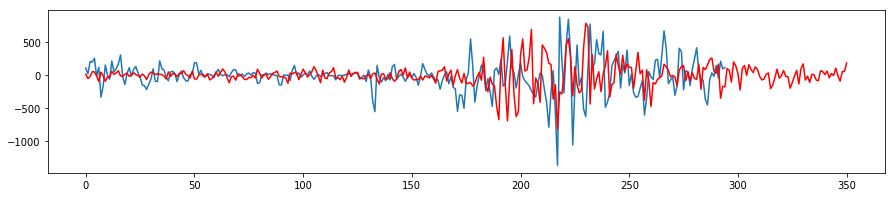

In [8]:
# Try with the best pattern (Dec 2017 boom)
model_ar = AR(train)
model_ar_fit = model_ar.fit()
predictions = model_ar_fit.predict(start=150,end=500)

plt.figure(figsize=(15,3))
plt.plot(test)
plt.plot(predictions,color='red')

If predictions seems to fit pretty well with the test data, it's only because of the parameters tunings (start=150,end=500). This precise configuration reproduces the bitcoin price variations of the boom in december 2017. And this not looks that bad even if the result is not exploitable as such.<br /><br />
Let's take a step back. Are there series in bitcoin historical price?<br /><br />

## Looking for series

In [9]:
# Extract the BTC price boom of 2013
first_boom = get_csv_scrap_btc(start_date='20130501',end_date = '20160101')
first_boom['Price'] = (first_boom['High'] + first_boom['Low']) / 2
first_boom = first_boom[['Date', 'Price']].set_index('Date')

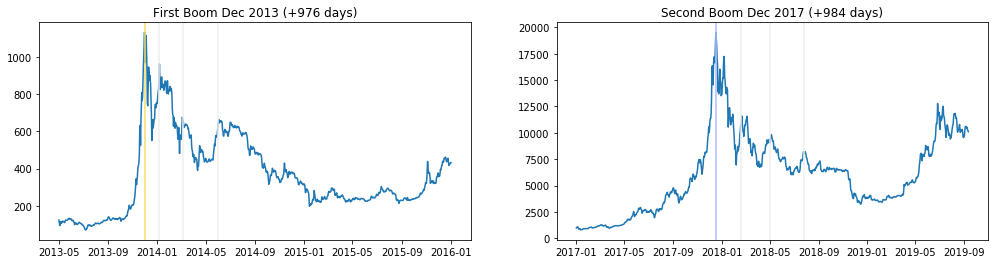

In [10]:
# Let's plot that!
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,4))

ax1.plot(first_boom)
ax1.set_title(f'First Boom Dec 2013 (+{first_boom.size} days)')
ax1.axvline(x='2013-11-30',color='#f9dd68')
ax1.axvline(x='2014-01-05',color='#EEEEEE')
ax1.axvline(x='2014-03-05',color='#EEEEEE')
ax1.axvline(x='2014-06-01',color='#EEEEEE')

ax2.plot(df)
ax2.set_title(f'Second Boom Dec 2017 (+{df.size} days)')
ax2.axvline(x='2017-12-17',color='#b1baff')
ax2.axvline(x='2018-02-17',color='#EEEEEE')
ax2.axvline(x='2018-05-01',color='#EEEEEE')
ax2.axvline(x='2018-07-25',color='#EEEEEE')
#ax2.axvline(x='2019-06-25',color='#EEEEEE')

### First instant cautious conclusions:
- This look nice, and interesting. The scenario (+950 days period) seems to be repeated.
- I wonder if this is the typical pattern after a burst of speculative bubble (soaring, burst, consolidation, ..).
- Going more in depth, maybe we could find a boom like this earlier in historical data (with same proportions).
<br /><br />
So now, i'm really curious to know, how much these two are correlated and what happend between the two booms.

In [11]:
df_c = df.copy()
df_c = df[df.size - first_boom.size:].copy()
df_c['first_boom'] = first_boom['Price'].tolist()

df_c.corr().values[0][1]

0.37243701064659934

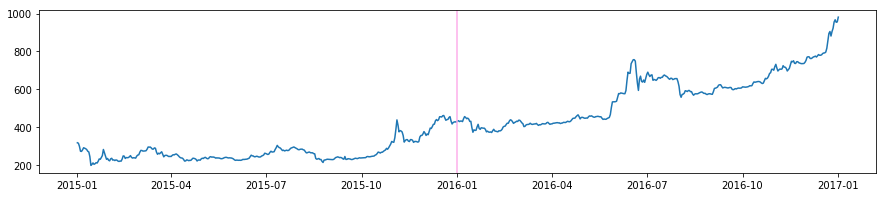

In [12]:
# Extract the BTC price boom of 2013
btw_boom = get_csv_scrap_btc(start_date='20150101',end_date = '20170101')
btw_boom['Price'] = (btw_boom['High'] + btw_boom['Low']) / 2
btw_boom = btw_boom[['Date', 'Price']].set_index('Date')

plt.figure(figsize=(15,3))
plt.plot(btw_boom)
plt.axvline(x='2016-01-01',color='#fdafea')

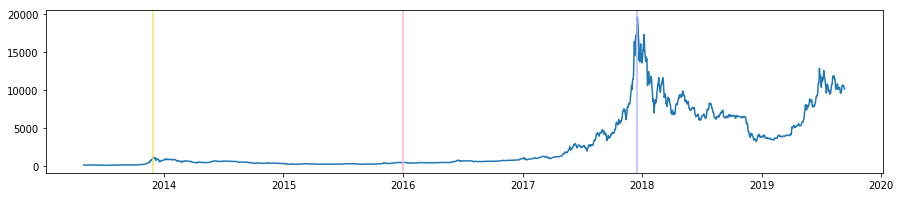

In [13]:
# Extract the BTC price 2013 to 2019
btw_boom = get_csv_scrap_btc(start_date='20130501',end_date = '20190912')
btw_boom['Price'] = (btw_boom['High'] + btw_boom['Low']) / 2
btw_boom = btw_boom[['Date', 'Price']].set_index('Date')

plt.figure(figsize=(15,3))
plt.plot(btw_boom)
plt.axvline(x='2013-11-30',color='#f9dd68')
plt.axvline(x='2016-01-01',color='#fdafea')
plt.axvline(x='2017-12-17',color='#b1baff')

## Facts/questions thinking:
- People get rich in the BTC boom of 2014
- People get rich in the BTC boom of 2019
- Crypto is a risky cocktails : high volatility, price manipulation.. but incredible gains are possible.
- BTC price boom happened at least twice (the biggest was december 2017).
- How many people want to make it happend again ? 
- How much few people ("whales") can manipulate the price ?
<br /><br />
The price evolution shows on the last plot is insane. And after my recent explorations, i can easily bet that a time-series for long term predictions on BTC price can be applicate. The paper i read on the very beginning of this notebook use ARIMA to predict the BTC price on the next. I'm not trading daily, so my goal is to predict week+1 price, or +2 years like examples above.
<br /><br />
What (will) have a big impact is government laws, regulation of crypto, taxes, etc. And this evolving to protect and regulate this investment opportunity.  

In [ ]:
# ARIMA Model
#from statsmodels.tsa.arima_model import ARIMA
# ARIMA(df, order=(p,d,q))
# p = periods taken for autoregressive model
# d = Integrated order, difference
# q = periods in moving average model
#arima = ARIMA(df,order=(9, 2, 0))
#arima = arima.fit()
#arima.aic
#predictions= arima.forecast(steps=10)[0]
#mean_squared_error(test,predictions)

In [ ]:
#import itertools
#p=d=q=range(0,5)
#pdq = list(itertools.product(p,d,q))
#for param in pdq:
#    try:
#        model_arima = ARIMA(train,order=param)
#        model_arima_fit = model_arima.fit()
#        print(param,model_arima_fit.aic)
#    except:
#        continue

In [ ]:
#print(df.head())
#print('\n','>>> shift()')
#print(df.shift().head())
#print('\n','>>> diff()')
#print(df.diff(periods=1).head())

In [ ]:
#f, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,6))
#ax1.set_title('End 2018 (50 days)')
#ax1.plot(predictions[0:50])
#ax1.plot(test[0:50])

#ax2.set_title('2019 (200 days)')
#ax2.plot(predictions[50:250])
#ax2.plot(test[50:250])